In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [11]:
import os
import warnings

warnings.filterwarnings("ignore") 

In [13]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [14]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [15]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [16]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [17]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [18]:
df['id']=df['Store'].astype(str) + '-'+ df['Dept'].astype(str)

df.groupby('id').agg({'Date':'count'}).reset_index().sort_values(by='Date')

result = df.groupby('id').agg({'Date':'count'}).reset_index()
result = result[result['Date'] == 143].sort_values(by='Date')
result

,id,Date
0,1-1,143
2162,35-42,143
2163,35-44,143
2165,35-46,143
2168,35-5,143
...,...,...
1069,21-82,143
1070,21-83,143
1071,21-85,143
1073,21-9,143


In [19]:
df = df[df['id'].isin(result['id'])]

In [20]:
# reduce running time by forecasting only top 7 stores
top_7_stores = df.groupby(['Store']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(7)
df = df[df['Store'].isin(top_7_stores['Store'])]

In [21]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [22]:
df_features=df[['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Weekly_Sales','Date']]

correlation_matrix = df_features.corr()

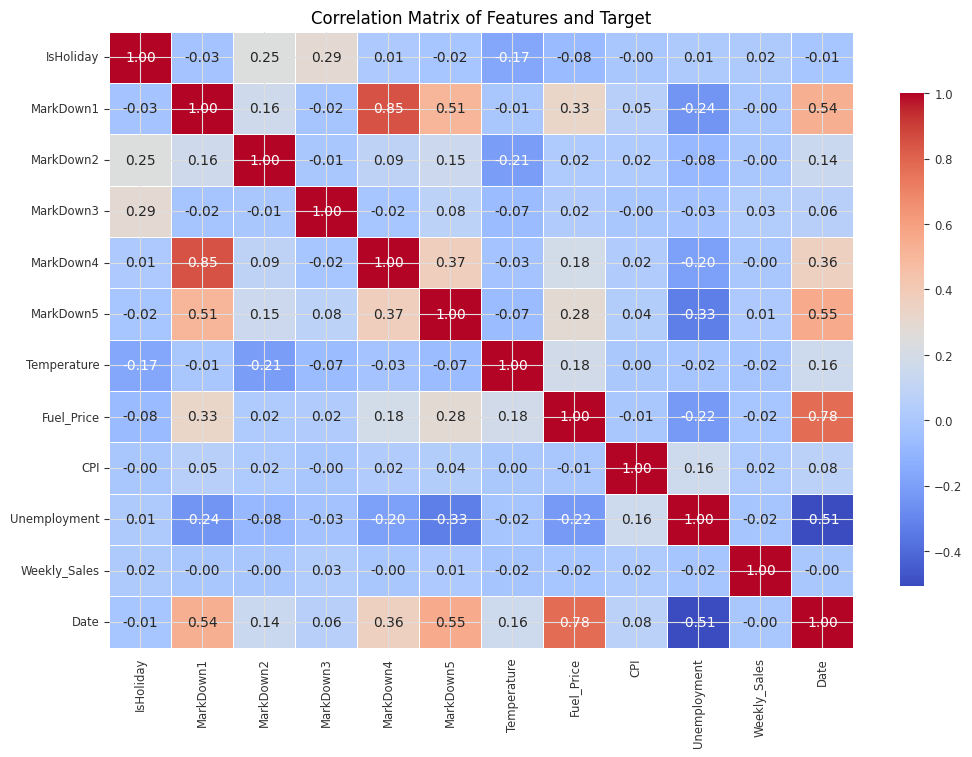

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Features and Target')
plt.show()

In [24]:
print("Descrição de Weekly_Sales:")
print(df['Weekly_Sales'].describe())


Descrição de Weekly_Sales:
count     67353.000000
mean      29149.581407
std       34188.366729
min           0.000000
25%        6589.130000
50%       16164.880000
75%       39247.830000
max      693099.360000
Name: Weekly_Sales, dtype: float64


In [25]:
import pandas as pd

lower_sales = df.nsmallest(20, 'Weekly_Sales')

print(lower_sales)

        Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
92453      10    36 2012-02-10          0.00          1    B  medium   
130514     14    19 2010-07-23          0.00          0    A  medium   
95778      10    80 2010-04-09          4.98          0    B  medium   
130518     14    19 2010-08-20         13.03          0    A  medium   
95806      10    80 2010-10-22         15.92          0    B  medium   
259195     27    19 2010-05-21         23.97          0    A   large   
259205     27    19 2010-07-30         25.00          0    A   large   
130510     14    19 2010-06-25         28.00          0    A  medium   
130569     14    19 2011-08-12         31.10          0    A  medium   
95807      10    80 2010-10-29         33.84          0    B  medium   
259201     27    19 2010-07-02         34.25          0    A   large   
130509     14    19 2010-06-18         35.00          0    A  medium   
130539     14    19 2011-01-14         36.00          0    A  me

In [26]:
import pandas as pd

top_sales = df.nlargest(20, 'Weekly_Sales')

print(top_sales)

        Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
95373      10    72 2010-11-26     693099.36          1    B  medium   
95425      10    72 2011-11-25     630999.19          1    B  medium   
135665     14    72 2010-11-26     474330.10          1    A  medium   
195088     20    72 2010-11-26     422306.25          1    A   large   
264390     27    72 2010-11-26     420586.57          1    A   large   
88428      10     7 2010-12-24     406988.63          0    B  medium   
95377      10    72 2010-12-24     404245.03          0    B  medium   
195140     20    72 2011-11-25     392023.02          1    A   large   
37253       4    72 2011-11-25     385051.04          1    A   large   
37201       4    72 2010-11-26     381072.11          1    A   large   
135717     14    72 2011-11-25     375948.31          1    A  medium   
264442     27    72 2011-11-25     368484.19          1    A   large   
128984     14     7 2010-12-24     356867.25          0    A  me

In [27]:
def mostrar(data):
    sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs Temperature')
    plt.show()

    sns.scatterplot(x='MarkDown1', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs MarkDown1')
    plt.show()

    sns.scatterplot(x='MarkDown2', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs MarkDown2')
    plt.show()

    sns.scatterplot(x='MarkDown1', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs MarkDown3')
    plt.show()

    sns.scatterplot(x='MarkDown4', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs MarkDown4')
    plt.show()

    sns.scatterplot(x='MarkDown5', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs MarkDown5')
    plt.show()

    sns.scatterplot(x='CPI', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs CPI')
    plt.show()

    sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs Fuel_Price')
    plt.show()

    sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=data)
    plt.title('Weekly_Sales vs Unemployment')
    plt.show()
    

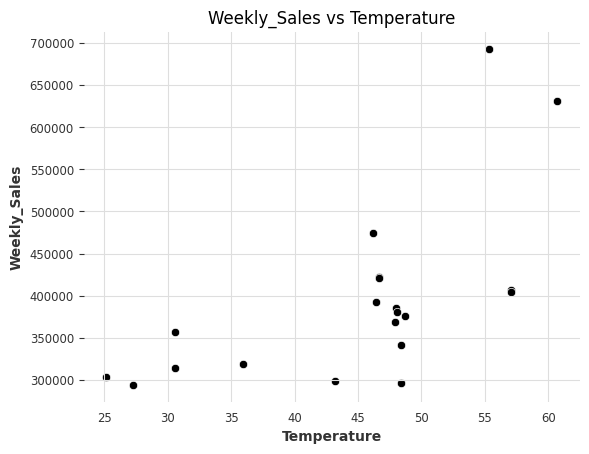

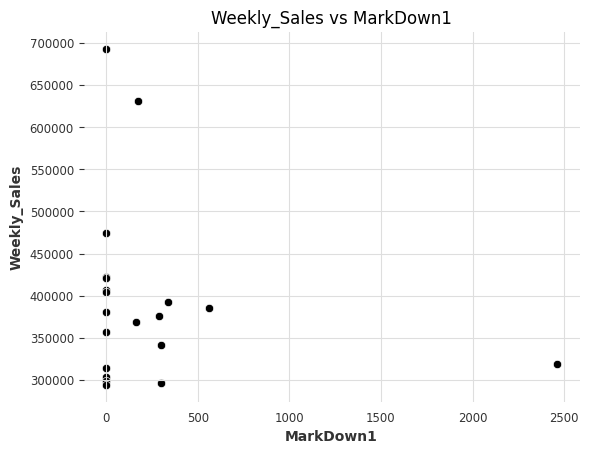

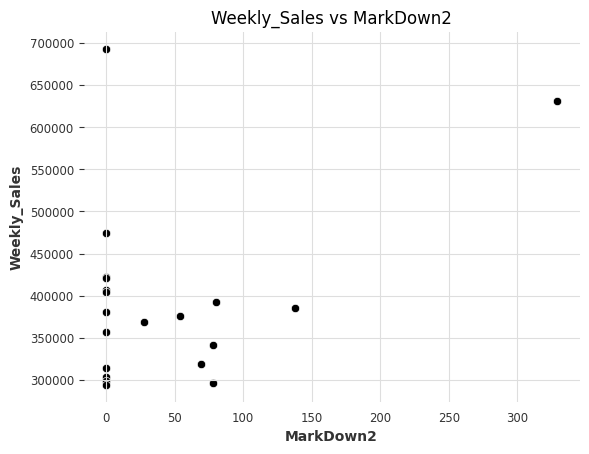

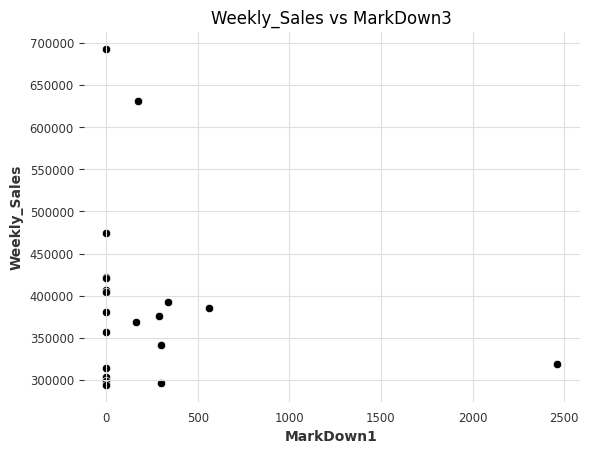

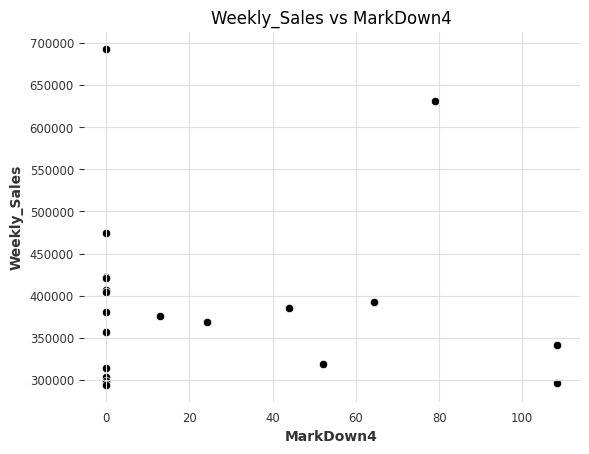

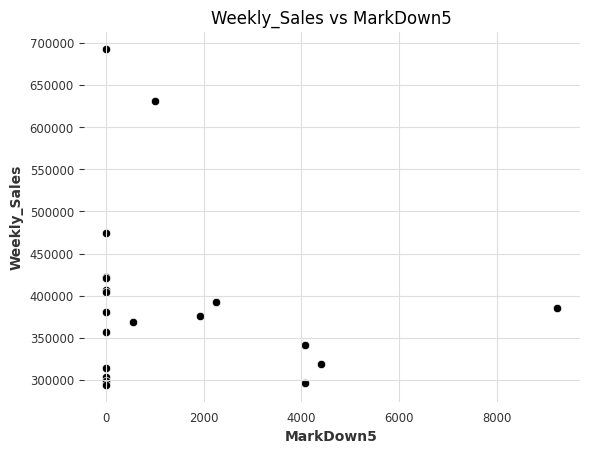

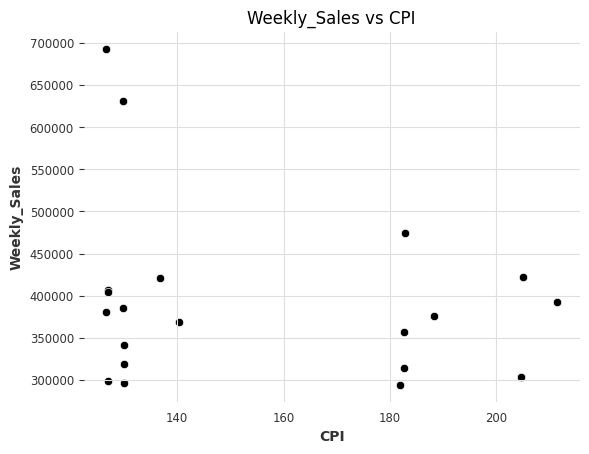

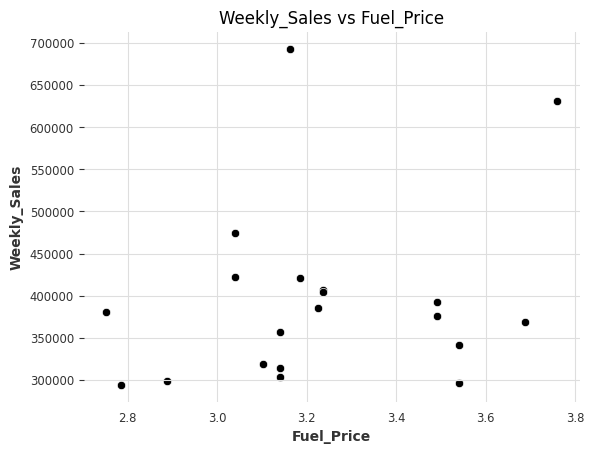

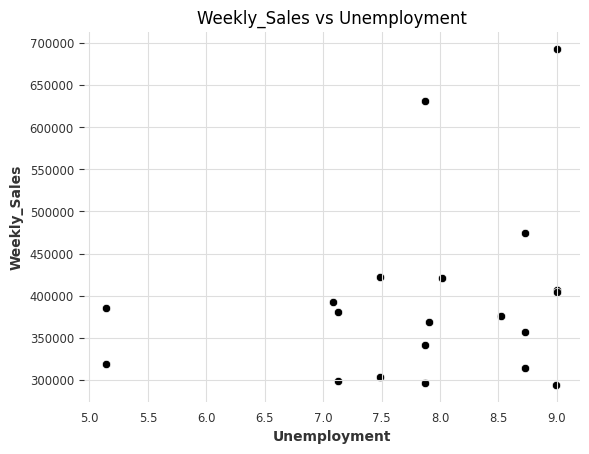

In [28]:
mostrar(top_sales)

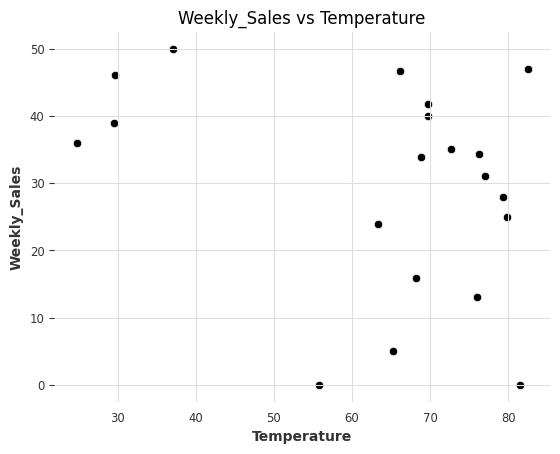

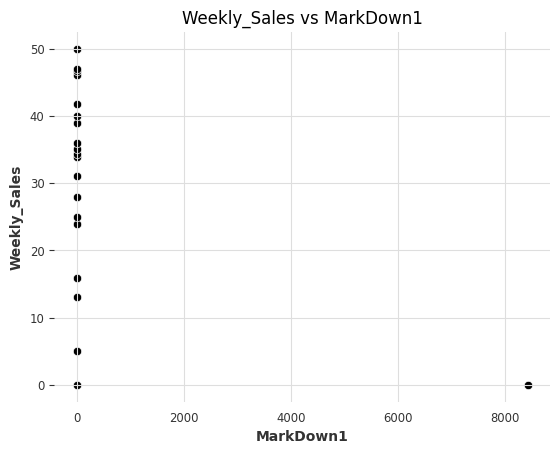

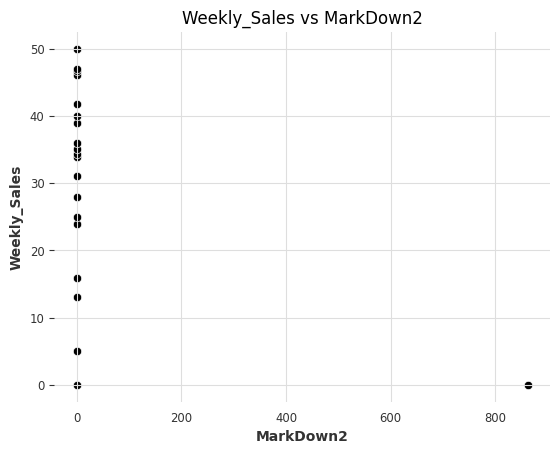

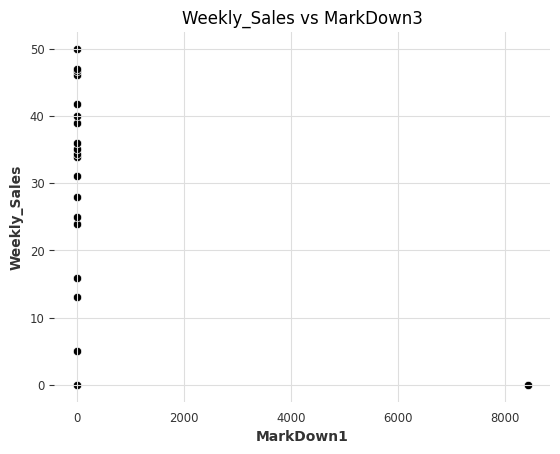

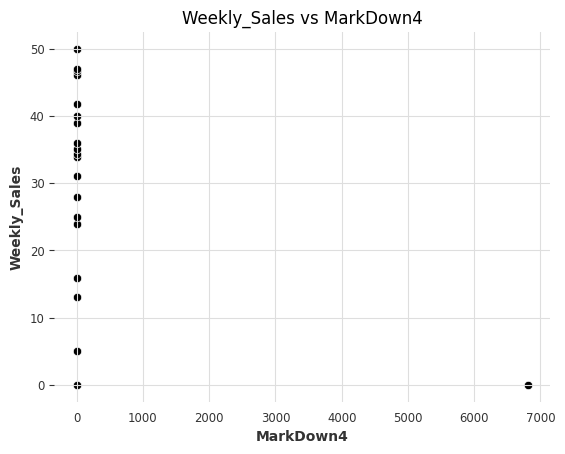

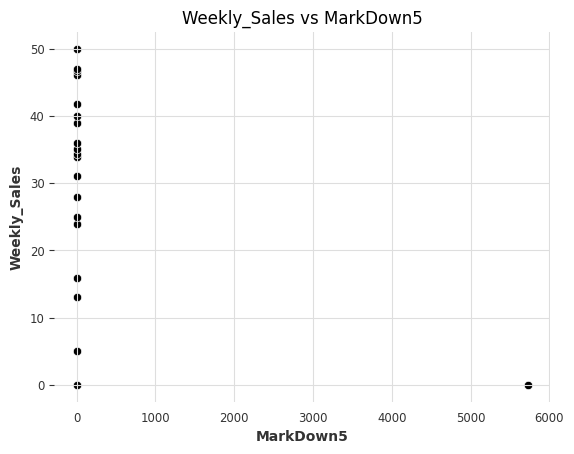

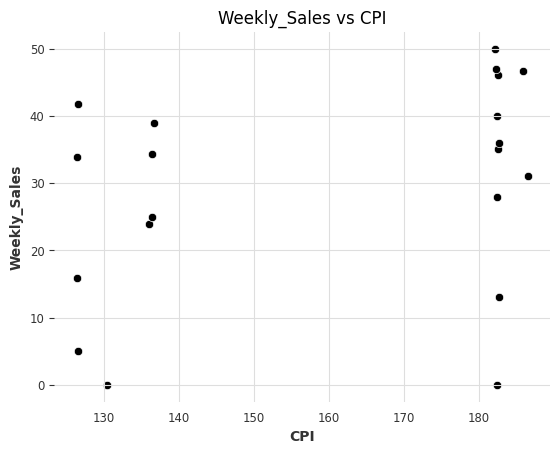

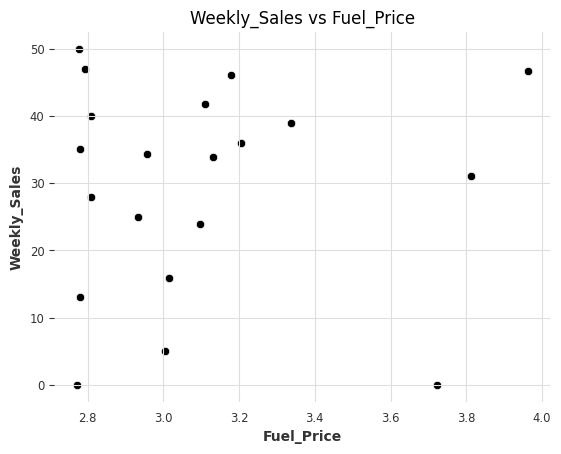

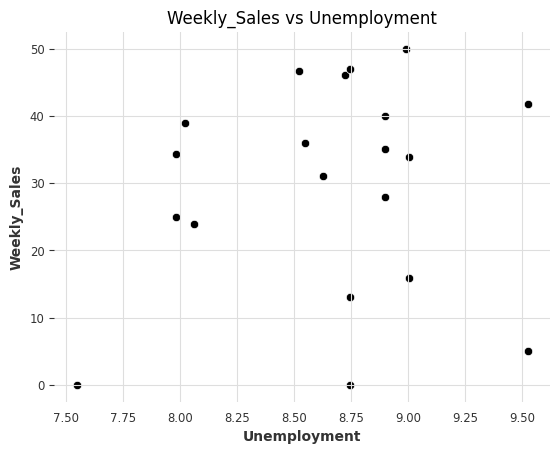

In [29]:
mostrar(lower_sales)

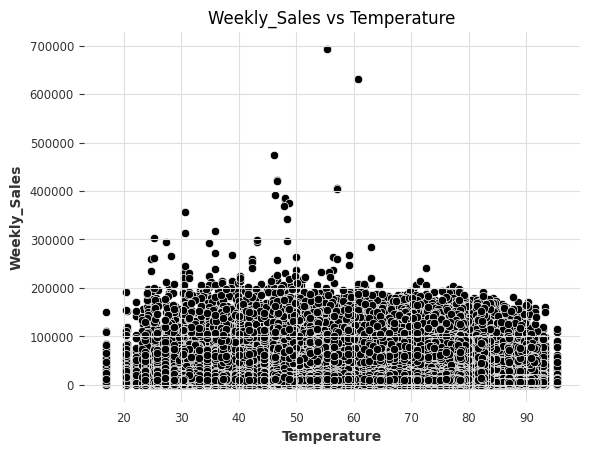

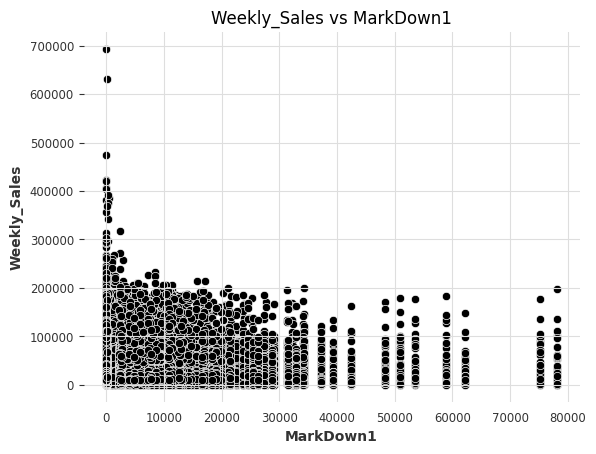

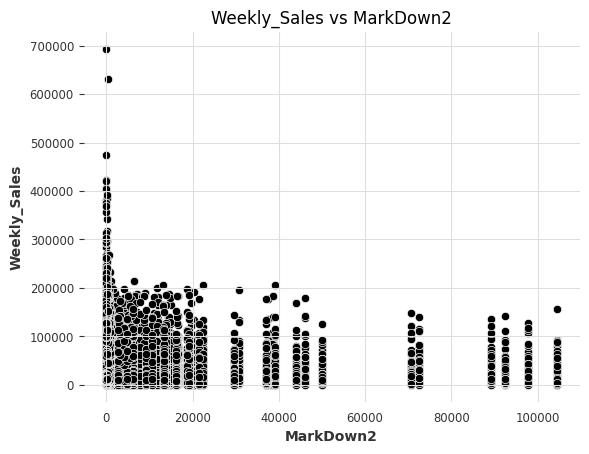

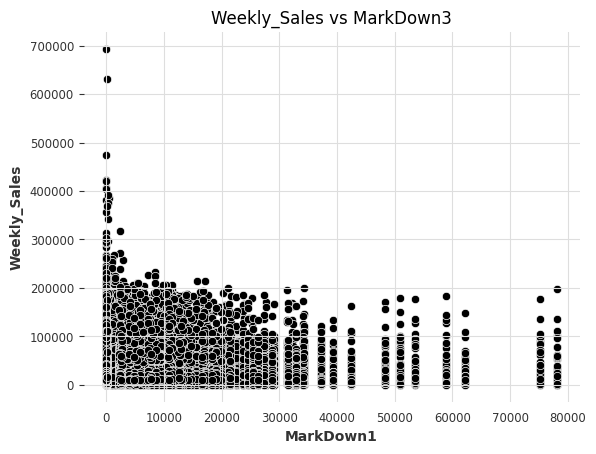

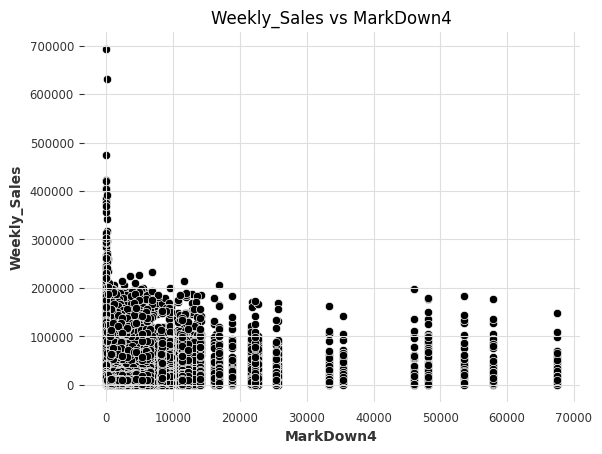

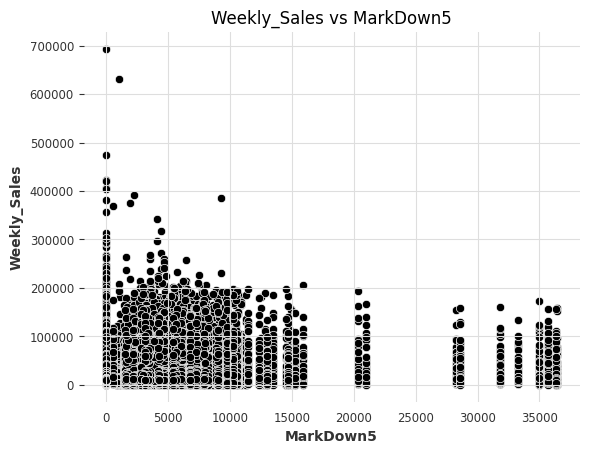

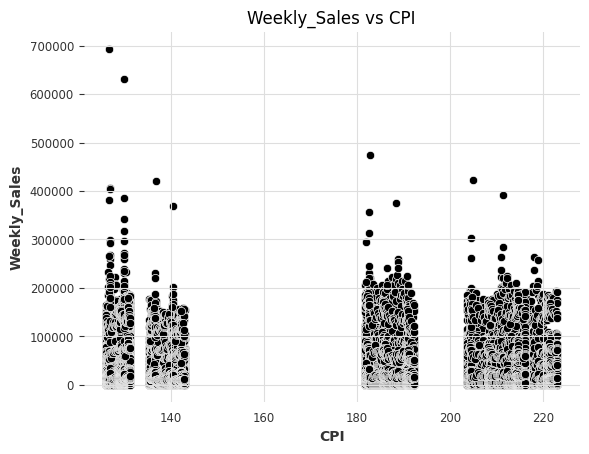

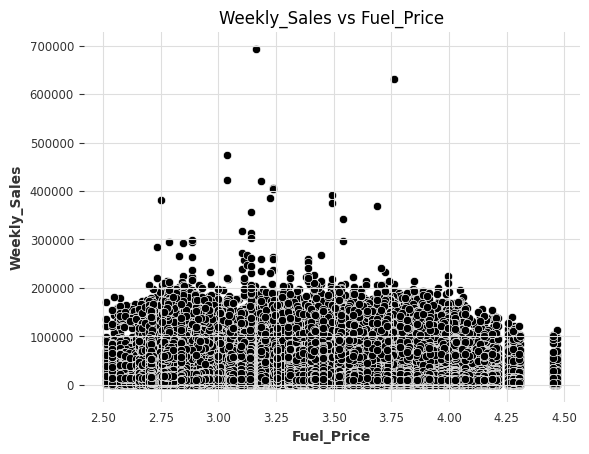

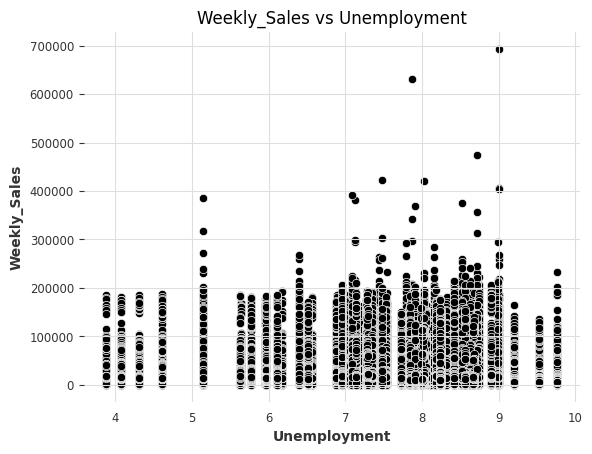

In [30]:
mostrar(df)